In [1]:
import heeps
import os.path
import numpy as np
import pyfftw.interfaces.numpy_fft as fftw
import proper
import inspect
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

## Initialize wavefront

In [2]:
conf = dict(
    dir_output = 'benchmark_fft',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_phase = 'wavefront/cube_Cbasic_20201130_3600s_300ms_0piston_meters_scao_only_285.fits',
    nframes = 600,
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf) 
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
phase_screens, amp_screens, tiptilts, misaligns = heeps.wavefront.load_errors(verbose=True, **conf)
folder = conf['dir_output']

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   ravc_calc=True, ravc_t=0.7608, ravc_r=0.6213
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil from 'ELT_fullM1.fits'
Load phase screens from 'cube_Cbasic_20201130_3600s_300ms_0piston_meters_scao_only_285.fits'
   nscreens=600 (nframes=600, nstep=1)


## Comparison of FFT methods

In [3]:
# use custom 'lens' function (currently renamed to 'lens_test')
def propag(wfi, case, verbose=True):
    wf = deepcopy(wfi)
    conf.update(
        dir_output = os.path.join(folder, case),
        lens_method = case, # fft method: 'proper', 'pyfftw', 'numpy'
    )
    psf = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, verbose=verbose, **conf)
    psfs = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens, \
        amp_screens=amp_screens, tiptilts=tiptilts, misaligns=misaligns, onaxis=True, \
        savefits=True, verbose=verbose, **conf)
    #sep, adi = heeps.contrast.cc_adi(savepsf=True, savefits=True, verbose=verbose, **conf)
    return psfs

Create single off-axis PSF
   apply ring apodizer: ravc_t=0.7608, ravc_r=0.6213
   apply lyot stop from 'ls_ravc_allglass_285.fits'
   extract PSF on the detector: ndet=403
Create on-axis PSF cube
   2021-04-10 12:18:44: e2e simulation starts, using 10 cores
   2021-04-10 12:22:36: finished, elapsed 231.824 seconds


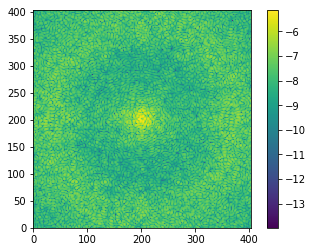

In [4]:
# case 1: current HEEPS, using PROPER
cube1 = propag(wf, 'proper')
plt.imshow(np.log10(cube1[0]), origin='lower'), plt.colorbar();

Create single off-axis PSF
   apply ring apodizer: ravc_t=0.7608, ravc_r=0.6213
   apply lyot stop from 'ls_ravc_allglass_285.fits'
   extract PSF on the detector: ndet=403
Create on-axis PSF cube
   2021-04-10 12:22:38: e2e simulation starts, using 10 cores
   2021-04-10 12:26:38: finished, elapsed 239.854 seconds
std(cube2/cube1) = 0.0012356460210643475
'All close' = False


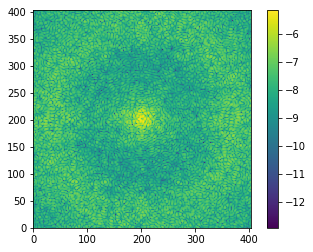

In [5]:
# case 2: using pyFFTW
cube2 = propag(wf, 'pyfftw')
plt.imshow(np.log10(cube2[0]), origin='lower'), plt.colorbar();
print('std(cube2/cube1) = %s'%np.std(np.sum(cube2, (1,2))/np.sum(cube1, (1,2))))
print("'All close' = %s"%np.allclose(cube2, cube1))

Create single off-axis PSF
   apply ring apodizer: ravc_t=0.7608, ravc_r=0.6213
   apply lyot stop from 'ls_ravc_allglass_285.fits'
   extract PSF on the detector: ndet=403
Create on-axis PSF cube
   2021-04-10 12:26:41: e2e simulation starts, using 10 cores
   2021-04-10 12:30:32: finished, elapsed 230.709 seconds
std(cube3/cube1) = 0.001235646021064353
'All close' = False


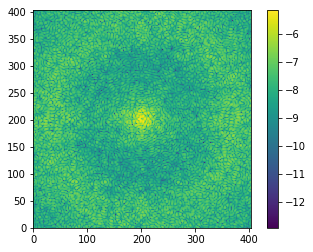

In [6]:
# case 3: using NumPy
cube3 = propag(wf, 'numpy')
plt.imshow(np.log10(cube3[0]), origin='lower'), plt.colorbar();
print('std(cube3/cube1) = %s'%np.std(np.sum(cube3, (1,2))/np.sum(cube1, (1,2))))
print("'All close' = %s"%np.allclose(cube3, cube1))

## show PROPER function code source

In [7]:
print(inspect.getsource(proper.prop_lens))

def prop_lens(wf, lens_fl, surface_name = ""):
    """Alter the current wavefront as a perfect lens would. 
    
    This routine computes the phase change cause by a perfect lens that has a 
    focal length specified by the user. A positive focal length corresponds to 
    a convex lens or concave mirror; a negative length corresponds to a concave 
    lens or convex mirror. This routine updates the new beam waist position.
    
    Parameters
    ----------
    wf : obj
        WaveFront class object
        
    lens_fl : float
        Focal length of lens in meters
        
    surface_name : str
        String containing name of surface; used when printing out that a lens 
        is being applied
        
    Returns
    -------
        None
        Modifies wavefront array in wf object.
    """
    rayleigh_factor = proper.rayleigh_factor
    
    if proper.print_it:
        if surface_name == "":
            print( "Applying lens" ) 
        else:
            print( "Applying 